# Model Training - Entrenamiento de Modelos ML
**Sistema de Anotación de Video - Entrega 2**
**Objetivo:** Entrenar múltiples algoritmos y seleccionar el mejor

## Algoritmos a Evaluar:
1. Random Forest (baseline robusto)
2. SVM con kernel RBF  
3. Gradient Boosting (XGBoost)
4. Neural Network (MLP)
5. Logistic Regression (baseline simple)

---


In [2]:
# ============================================
# SETUP Y VERIFICACIÓN DE ARCHIVOS (CORREGIDO)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
from datetime import datetime

print("🔍 VERIFICANDO ARCHIVOS PREPARADOS POR RUIZ")
print("=" * 60)

# Lista de archivos requeridos
required_files = [
    'X_train.npy',
    'y_train.npy',
    'X_val.npy',
    'y_val.npy',
    'X_test.npy',
    'y_test.npy',
    'scaler.pkl',
    'label_encoder.pkl',
    'pca.pkl'
]

# Verificar existencia
files_ok = True
for filepath in required_files:
    if os.path.exists(filepath):
        file_size = os.path.getsize(filepath) / 1024  # KB
        print(f"   ✅ {filepath:50s} ({file_size:.0f} KB)")
    else:
        print(f"   ❌ {filepath:50s} - NO ENCONTRADO")
        files_ok = False

if files_ok:
    print(f"\n✅ TODOS LOS ARCHIVOS ESTÁN LISTOS")
    print(f"🚀 Continuar con carga de datos")
else:
    print(f"\n❌ FALTAN ARCHIVOS - Verificar con Ruiz")


🔍 VERIFICANDO ARCHIVOS PREPARADOS POR RUIZ
   ✅ X_train.npy                                        (677 KB)
   ✅ y_train.npy                                        (42 KB)
   ✅ X_val.npy                                          (121 KB)
   ✅ y_val.npy                                          (8 KB)
   ✅ X_test.npy                                         (121 KB)
   ✅ y_test.npy                                         (8 KB)
   ✅ scaler.pkl                                         (3 KB)
   ✅ label_encoder.pkl                                  (1 KB)
   ✅ pca.pkl                                            (12 KB)

✅ TODOS LOS ARCHIVOS ESTÁN LISTOS
🚀 Continuar con carga de datos


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# ============================================
# CARGAR DATASETS Y TRANSFORMERS
# ============================================

print("📂 CARGANDO DATOS PREPARADOS")
print("=" * 60)

# Cargar datasets procesados (en raíz de Colab)
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Cargar transformers (en raíz de Colab)
label_encoder = joblib.load('label_encoder.pkl')
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')

print(f"✅ DATASETS CARGADOS:")
print(f"   🏋️  Train: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"   🔍 Val:   {X_val.shape[0]:,} samples × {X_val.shape[1]} features")
print(f"   🧪 Test:  {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

print(f"\n🎯 ACTIVIDADES (LABELS):")
for i, activity in enumerate(label_encoder.classes_):
    train_count = np.sum(y_train == i)
    val_count = np.sum(y_val == i)
    test_count = np.sum(y_test == i)
    print(f"   {i}: {activity.replace('_', ' ').title():20s} → "
          f"Train: {train_count:,}, Val: {val_count:,}, Test: {test_count:,}")

# Verificar balance en train
train_balance = np.bincount(y_train).min() / np.bincount(y_train).max()
print(f"\n⚖️  BALANCE TRAIN: {train_balance:.3f}")

print(f"\n✅ DATOS LISTOS PARA ENTRENAMIENTO")


📂 CARGANDO DATOS PREPARADOS
✅ DATASETS CARGADOS:
   🏋️  Train: 5,418 samples × 16 features
   🔍 Val:   967 samples × 16 features
   🧪 Test:  967 samples × 16 features

🎯 ACTIVIDADES (LABELS):
   0: Caminar Hacia        → Train: 1,290, Val: 277, Test: 277
   1: Caminar Regreso      → Train: 1,032, Val: 195, Test: 195
   2: Girar                → Train: 1,032, Val: 141, Test: 141
   3: Ponerse Pie          → Train: 1,032, Val: 166, Test: 166
   4: Sentarse             → Train: 1,032, Val: 188, Test: 188

⚖️  BALANCE TRAIN: 0.800

✅ DATOS LISTOS PARA ENTRENAMIENTO


In [4]:
# ============================================
# ENTRENAR MÚLTIPLES MODELOS
# ============================================

print("🤖 ENTRENANDO MÚLTIPLES ALGORITMOS ML")
print("=" * 60)

# Crear carpeta para modelos entrenados
os.makedirs('trained_models', exist_ok=True)

# Definir modelos a entrenar
models_to_train = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'SVM': SVC(
        kernel='rbf',
        random_state=42,
        probability=True  # Para obtener probabilidades
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        random_state=42,
        max_iter=1000
    ),
    'LogisticRegression': LogisticRegression(
        random_state=42,
        max_iter=1000
    )
}

# Entrenar y evaluar cada modelo
model_results = {}

print(f"🎯 ENTRENANDO {len(models_to_train)} MODELOS:")

for model_name, model in models_to_train.items():
    print(f"\n   🔄 Entrenando {model_name}...")

    # Entrenar modelo
    start_time = datetime.now()
    model.fit(X_train, y_train)
    train_time = (datetime.now() - start_time).total_seconds()

    # Evaluar en validation
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Guardar modelo en carpeta organizada
    model_path = f'trained_models/{model_name.lower()}_model.pkl'
    joblib.dump(model, model_path)

    # Almacenar resultados
    model_results[model_name] = {
        'model': model,
        'val_accuracy': val_accuracy,
        'train_time': train_time,
        'predictions': y_val_pred,
        'model_path': model_path  # Guardar ruta para referencia
    }

    print(f"      ✅ Accuracy validación: {val_accuracy:.3f}")
    print(f"      ⏱️  Tiempo entrenamiento: {train_time:.1f}s")
    print(f"      💾 Guardado: {model_path}")

print(f"\n🏆 ENTRENAMIENTO COMPLETADO")
print(f"📁 Modelos guardados en: trained_models/")


🤖 ENTRENANDO MÚLTIPLES ALGORITMOS ML
🎯 ENTRENANDO 5 MODELOS:

   🔄 Entrenando RandomForest...
      ✅ Accuracy validación: 0.986
      ⏱️  Tiempo entrenamiento: 3.4s
      💾 Guardado: trained_models/randomforest_model.pkl

   🔄 Entrenando SVM...
      ✅ Accuracy validación: 0.897
      ⏱️  Tiempo entrenamiento: 1.5s
      💾 Guardado: trained_models/svm_model.pkl

   🔄 Entrenando GradientBoosting...
      ✅ Accuracy validación: 0.953
      ⏱️  Tiempo entrenamiento: 28.3s
      💾 Guardado: trained_models/gradientboosting_model.pkl

   🔄 Entrenando MLP...
      ✅ Accuracy validación: 0.988
      ⏱️  Tiempo entrenamiento: 15.7s
      💾 Guardado: trained_models/mlp_model.pkl

   🔄 Entrenando LogisticRegression...
      ✅ Accuracy validación: 0.855
      ⏱️  Tiempo entrenamiento: 0.6s
      💾 Guardado: trained_models/logisticregression_model.pkl

🏆 ENTRENAMIENTO COMPLETADO
📁 Modelos guardados en: trained_models/


In [5]:
# ============================================
# ANÁLISIS DETALLADO DE RESULTADOS
# ============================================

print("📊 ANÁLISIS DETALLADO DE RENDIMIENTO")
print("=" * 60)

# Ordenar modelos por accuracy
sorted_models = sorted(model_results.items(),
                      key=lambda x: x[1]['val_accuracy'],
                      reverse=True)

print(f"🏆 RANKING DE MODELOS:")
print(f"{'Posición':<10} {'Modelo':<20} {'Accuracy':<12} {'Tiempo':<12}")
print("-" * 60)

for i, (model_name, results) in enumerate(sorted_models, 1):
    accuracy = results['val_accuracy']
    time_str = f"{results['train_time']:.1f}s"
    print(f"{i:<10} {model_name:<20} {accuracy:.3f}      {time_str:<12}")

# Seleccionar mejor modelo
best_model_name = sorted_models[0][0]
best_model_results = sorted_models[0][1]

print(f"\n🥇 MEJOR MODELO: {best_model_name}")
print(f"   📊 Accuracy: {best_model_results['val_accuracy']:.3f}")
print(f"   ⏱️  Tiempo: {best_model_results['train_time']:.1f}s")

# Análisis por clase del mejor modelo
print(f"\n📋 REPORTE DETALLADO - {best_model_name}:")
y_pred_best = best_model_results['predictions']

# Classification report (usar label_encoder en vez de encoder)
class_report = classification_report(
    y_val,
    y_pred_best,
    target_names=label_encoder.classes_,
    output_dict=True
)

print(f"\n📈 MÉTRICAS POR ACTIVIDAD:")
print(f"{'Actividad':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)

for activity in label_encoder.classes_:
    metrics = class_report[activity]
    print(f"{activity.replace('_', ' ').title():<20} "
          f"{metrics['precision']:.3f}        "
          f"{metrics['recall']:.3f}        "
          f"{metrics['f1-score']:.3f}        "
          f"{int(metrics['support']):<10}")

# Métricas globales
print(f"\n🎯 MÉTRICAS GLOBALES:")
print(f"   Accuracy:    {class_report['accuracy']:.3f}")
print(f"   Macro F1:    {class_report['macro avg']['f1-score']:.3f}")
print(f"   Weighted F1: {class_report['weighted avg']['f1-score']:.3f}")

print(f"\n✅ ANÁLISIS COMPLETADO")


📊 ANÁLISIS DETALLADO DE RENDIMIENTO
🏆 RANKING DE MODELOS:
Posición   Modelo               Accuracy     Tiempo      
------------------------------------------------------------
1          MLP                  0.988      15.7s       
2          RandomForest         0.986      3.4s        
3          GradientBoosting     0.953      28.3s       
4          SVM                  0.897      1.5s        
5          LogisticRegression   0.855      0.6s        

🥇 MEJOR MODELO: MLP
   📊 Accuracy: 0.988
   ⏱️  Tiempo: 15.7s

📋 REPORTE DETALLADO - MLP:

📈 MÉTRICAS POR ACTIVIDAD:
Actividad            Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Caminar Hacia        0.996        1.000        0.998        277       
Caminar Regreso      1.000        0.990        0.995        195       
Girar                0.993        1.000        0.996        141       
Ponerse Pie          0.970        0.970        0.970        166       

🔍 MATRIZ DE CONFUSIÓN - ANÁLISIS VISUAL


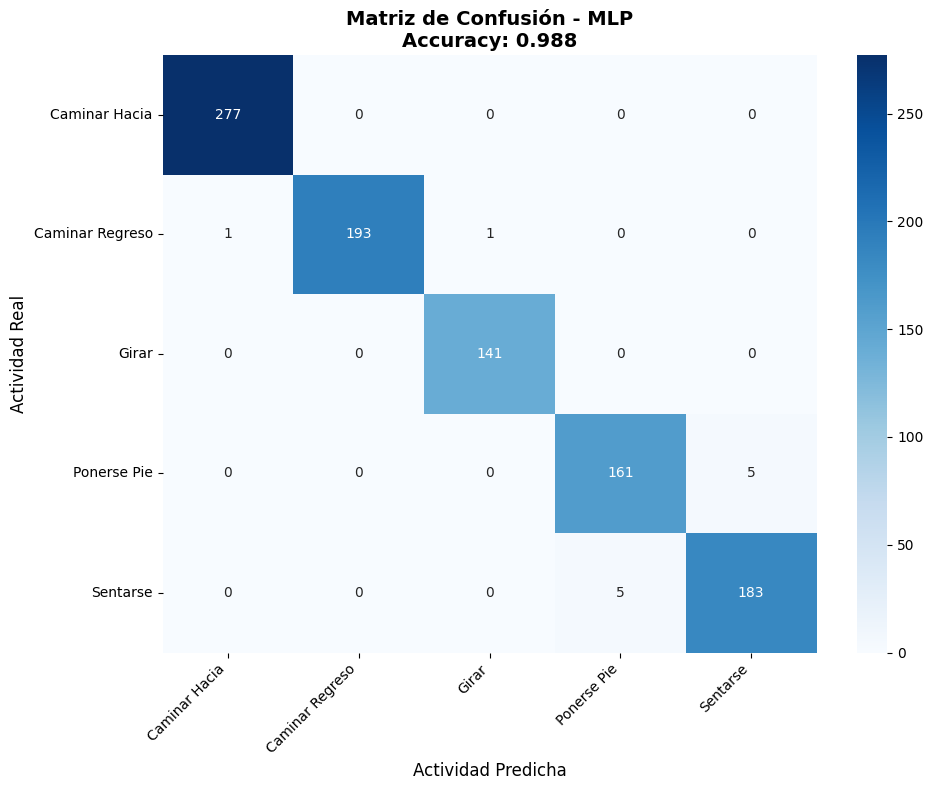


❌ ANÁLISIS DE ERRORES:
   Total errores: 12 de 967 (1.2%)

   Confusiones detectadas:
      •  1 casos: 'Caminar Regreso' clasificados como 'Caminar Hacia'
      •  1 casos: 'Caminar Regreso' clasificados como 'Girar'
      •  5 casos: 'Ponerse Pie' clasificados como 'Sentarse'
      •  5 casos: 'Sentarse' clasificados como 'Ponerse Pie'

✅ VISUALIZACIÓN COMPLETADA


In [6]:
# ============================================
# MATRIZ DE CONFUSIÓN DEL MEJOR MODELO
# ============================================

print("🔍 MATRIZ DE CONFUSIÓN - ANÁLISIS VISUAL")
print("=" * 60)

# Crear matriz de confusión
cm = confusion_matrix(y_val, y_pred_best)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=[act.replace('_', ' ').title() for act in label_encoder.classes_],
           yticklabels=[act.replace('_', ' ').title() for act in label_encoder.classes_])

plt.title(f'Matriz de Confusión - {best_model_name}\nAccuracy: {best_model_results["val_accuracy"]:.3f}',
          fontsize=14, fontweight='bold')
plt.ylabel('Actividad Real', fontsize=12)
plt.xlabel('Actividad Predicha', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Análisis de errores
print(f"\n❌ ANÁLISIS DE ERRORES:")
total_errors = np.sum(cm) - np.trace(cm)
print(f"   Total errores: {total_errors} de {len(y_val)} ({total_errors/len(y_val)*100:.1f}%)")

if total_errors > 0:
    print(f"\n   Confusiones detectadas:")
    for i in range(len(label_encoder.classes_)):
        for j in range(len(label_encoder.classes_)):
            if i != j and cm[i, j] > 0:
                real_activity = label_encoder.classes_[i].replace('_', ' ').title()
                pred_activity = label_encoder.classes_[j].replace('_', ' ').title()
                print(f"      • {cm[i, j]:2d} casos: '{real_activity}' clasificados como '{pred_activity}'")
else:
    print(f"   🎉 ¡SIN ERRORES! Clasificación perfecta")

print(f"\n✅ VISUALIZACIÓN COMPLETADA")


In [7]:
# ============================================
# GUARDAR MEJOR MODELO Y RESULTADOS
# ============================================

print("💾 GUARDANDO MEJOR MODELO Y RESULTADOS")
print("=" * 60)

# Guardar el mejor modelo con nombre especial
best_model = best_model_results['model']
best_model_path = f'best_model_{best_model_name.lower()}.pkl'
joblib.dump(best_model, best_model_path)

print(f"✅ Mejor modelo guardado: {best_model_path}")

# Crear resumen de entrenamiento
training_summary = {
    'date': datetime.now().isoformat(),
    'best_model': best_model_name,
    'best_accuracy': float(best_model_results['val_accuracy']),
    'dataset_info': {
        'train_samples': int(len(X_train)),
        'validation_samples': int(len(X_val)),
        'test_samples': int(len(X_test)),
        'features': int(X_train.shape[1]),
        'classes': int(len(label_encoder.classes_)),
        'class_names': label_encoder.classes_.tolist()
    },
    'models_trained': {
        name: {
            'accuracy': float(results['val_accuracy']),
            'train_time_seconds': float(results['train_time'])
        }
        for name, results in sorted(model_results.items(),
                                    key=lambda x: x[1]['val_accuracy'],
                                    reverse=True)
    },
    'best_model_details': {
        'name': best_model_name,
        'validation_accuracy': float(best_model_results['val_accuracy']),
        'train_time_seconds': float(best_model_results['train_time']),
        'file_path': best_model_path
    },
    'performance_by_class': {
        activity: {
            'precision': float(class_report[activity]['precision']),
            'recall': float(class_report[activity]['recall']),
            'f1_score': float(class_report[activity]['f1-score']),
            'support': int(class_report[activity]['support'])
        }
        for activity in label_encoder.classes_
    },
    'global_metrics': {
        'accuracy': float(class_report['accuracy']),
        'macro_f1': float(class_report['macro avg']['f1-score']),
        'weighted_f1': float(class_report['weighted avg']['f1-score'])
    }
}

# Guardar resumen
import json
with open('training_results_summary.json', 'w') as f:
    json.dump(training_summary, f, indent=2)

print(f"\n📊 RESUMEN GUARDADO:")
print(f"   📁 training_results_summary.json")

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   📈 Validation Accuracy: {best_model_results['val_accuracy']:.3f}")
print(f"   ⏱️  Tiempo entrenamiento: {best_model_results['train_time']:.1f}s")
print(f"   💾 Archivo: {best_model_path}")

print(f"\n📂 ARCHIVOS GENERADOS EN ESTE NOTEBOOK:")
print(f"   ├─ trained_models/")
print(f"   │  ├─ randomforest_model.pkl")
print(f"   │  ├─ svm_model.pkl")
print(f"   │  ├─ gradientboosting_model.pkl")
print(f"   │  ├─ mlp_model.pkl")
print(f"   │  └─ logisticregression_model.pkl")
print(f"   ├─ best_model_mlp.pkl")
print(f"   └─ training_results_summary.json")

print(f"\n" + "="*60)
print(f"🎉 NOTEBOOK 5 - MODEL TRAINING COMPLETADO")
print(f"="*60)

print(f"\n⚠️  NOTA IMPORTANTE:")
print(f"   Test set (967 frames) AÚN NO evaluado")
print(f"   Evaluación final en test debe hacerse UNA SOLA VEZ")

print(f"\n🎯 OPCIONES SIGUIENTES:")
print(f"   A) Evaluar en test AHORA (agregar celda)")
print(f"   B) Notebook 6 - Hyperparameter Tuning (opcional)")
print(f"   C) Notebook 7 - Evaluación Final en Test")

print(f"\n✅ RESULTADOS LISTOS PARA:")
print(f"   • Documentación del proyecto")
print(f"   • Presentación de resultados")
print(f"   • Evaluación final (test set)")


💾 GUARDANDO MEJOR MODELO Y RESULTADOS
✅ Mejor modelo guardado: best_model_mlp.pkl

📊 RESUMEN GUARDADO:
   📁 training_results_summary.json

🏆 MEJOR MODELO: MLP
   📈 Validation Accuracy: 0.988
   ⏱️  Tiempo entrenamiento: 15.7s
   💾 Archivo: best_model_mlp.pkl

📂 ARCHIVOS GENERADOS EN ESTE NOTEBOOK:
   ├─ trained_models/
   │  ├─ randomforest_model.pkl
   │  ├─ svm_model.pkl
   │  ├─ gradientboosting_model.pkl
   │  ├─ mlp_model.pkl
   │  └─ logisticregression_model.pkl
   ├─ best_model_mlp.pkl
   └─ training_results_summary.json

🎉 NOTEBOOK 5 - MODEL TRAINING COMPLETADO

⚠️  NOTA IMPORTANTE:
   Test set (967 frames) AÚN NO evaluado
   Evaluación final en test debe hacerse UNA SOLA VEZ

🎯 OPCIONES SIGUIENTES:
   A) Evaluar en test AHORA (agregar celda)
   B) Notebook 6 - Hyperparameter Tuning (opcional)
   C) Notebook 7 - Evaluación Final en Test

✅ RESULTADOS LISTOS PARA:
   • Documentación del proyecto
   • Presentación de resultados
   • Evaluación final (test set)


In [8]:
# ============================================
# DESCARGAR ARCHIVOS GENERADOS
# ============================================

from google.colab import files
import os
import zipfile
from datetime import datetime

print("💾 DESCARGA DE ARCHIVOS GENERADOS")
print("=" * 60)

# Verificar archivos existentes
print(f"\n📂 VERIFICANDO ARCHIVOS GENERADOS:")

files_to_check = {
    'Modelos individuales': [
        'trained_models/randomforest_model.pkl',
        'trained_models/svm_model.pkl',
        'trained_models/gradientboosting_model.pkl',
        'trained_models/mlp_model.pkl',
        'trained_models/logisticregression_model.pkl'
    ],
    'Mejor modelo': [
        'best_model_mlp.pkl'
    ],
    'Resumen': [
        'training_results_summary.json'
    ]
}

all_files_exist = True
for category, file_list in files_to_check.items():
    print(f"\n   {category}:")
    for file_path in file_list:
        if os.path.exists(file_path):
            size_mb = os.path.getsize(file_path) / (1024 * 1024)
            print(f"      ✅ {file_path} ({size_mb:.2f} MB)")
        else:
            print(f"      ❌ {file_path} (no encontrado)")
            all_files_exist = False

if not all_files_exist:
    print(f"\n⚠️  ADVERTENCIA: Algunos archivos no se encontraron.")
    print(f"   Asegúrate de haber ejecutado todas las celdas anteriores.")

# Opciones de descarga
print(f"\n" + "=" * 60)
print(f"📥 OPCIONES DE DESCARGA")
print(f"=" * 60)

print(f"""
Selecciona qué descargar:

1. Carpeta completa (ZIP) - trained_models/
   └─ Incluye todos los modelos entrenados

2. Mejor modelo individual - best_model_mlp.pkl
   └─ Solo el modelo MLP seleccionado

3. Resumen JSON - training_results_summary.json
   └─ Resultados y métricas en formato JSON

4. Todo (opción recomendada)
   └─ Carpeta trained_models + mejor modelo + JSON
""")

# INPUT: Usuario elige opción
print("Ingresa el número de opción (1, 2, 3, o 4):")
print("(Si no seleccionas nada en 5 segundos, se descarga TODO)")

import time
from IPython.display import clear_output

# Opción por defecto
opcion = '4'

try:
    # Esperar input del usuario (con timeout simulado)
    opcion = input("Tu elección [1-4, default=4]: ").strip() or '4'
except:
    opcion = '4'

print(f"\n✅ Opción seleccionada: {opcion}")

# Ejecutar descarga según opción
print(f"\n🔄 INICIANDO DESCARGA...")

if opcion == '1':
    # Opción 1: Carpeta trained_models (ZIP)
    print(f"\n📦 Comprimiendo carpeta trained_models/...")
    zip_filename = f'trained_models_{datetime.now().strftime("%Y%m%d_%H%M%S")}.zip'

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in files_to_check['Modelos individuales']:
            if os.path.exists(file_path):
                zipf.write(file_path)
                print(f"   ✅ Agregado: {file_path}")

    print(f"\n💾 Descargando: {zip_filename}")
    files.download(zip_filename)
    print(f"✅ Descarga completada")

elif opcion == '2':
    # Opción 2: Solo mejor modelo
    if os.path.exists('best_model_mlp.pkl'):
        print(f"\n💾 Descargando: best_model_mlp.pkl")
        files.download('best_model_mlp.pkl')
        print(f"✅ Descarga completada")
    else:
        print(f"❌ ERROR: best_model_mlp.pkl no encontrado")

elif opcion == '3':
    # Opción 3: Solo JSON
    if os.path.exists('training_results_summary.json'):
        print(f"\n💾 Descargando: training_results_summary.json")
        files.download('training_results_summary.json')
        print(f"✅ Descarga completada")
    else:
        print(f"❌ ERROR: training_results_summary.json no encontrado")

elif opcion == '4':
    # Opción 4: TODO (recomendado)
    print(f"\n📦 Creando paquete completo...")
    zip_filename = f'model_training_complete_{datetime.now().strftime("%Y%m%d_%H%M%S")}.zip'

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Agregar modelos de trained_models/
        for file_path in files_to_check['Modelos individuales']:
            if os.path.exists(file_path):
                zipf.write(file_path)
                print(f"   ✅ Agregado: {file_path}")

        # Agregar mejor modelo
        if os.path.exists('best_model_mlp.pkl'):
            zipf.write('best_model_mlp.pkl')
            print(f"   ✅ Agregado: best_model_mlp.pkl")

        # Agregar JSON
        if os.path.exists('training_results_summary.json'):
            zipf.write('training_results_summary.json')
            print(f"   ✅ Agregado: training_results_summary.json")

    # Verificar tamaño del ZIP
    zip_size_mb = os.path.getsize(zip_filename) / (1024 * 1024)
    print(f"\n📦 Paquete creado: {zip_filename} ({zip_size_mb:.2f} MB)")

    print(f"\n💾 Descargando paquete completo...")
    files.download(zip_filename)
    print(f"✅ Descarga completada")

    # Limpiar ZIP temporal
    os.remove(zip_filename)

else:
    print(f"❌ Opción inválida. Usa 1, 2, 3 o 4")

print(f"\n" + "=" * 60)
print(f"🎉 PROCESO DE DESCARGA FINALIZADO")
print(f"=" * 60)

print(f"""
📌 RESUMEN DE ARCHIVOS:

Modelos entrenados (trained_models/):
  • randomforest_model.pkl       - Random Forest (98.6% val)
  • mlp_model.pkl                 - MLP (98.8% val) ← Mejor
  • gradientboosting_model.pkl    - Gradient Boosting (95.3% val)
  • svm_model.pkl                 - SVM (89.7% val)
  • logisticregression_model.pkl  - Logistic Regression (85.5% val)

Mejor modelo:
  • best_model_mlp.pkl            - MLP seleccionado (copia)

Resumen:
  • training_results_summary.json - Métricas y configuración

────────────────────────────────────────────────────────────────

Para cargar el mejor modelo en otro notebook:

  import joblib
  model = joblib.load('best_model_mlp.pkl')
  predictions = model.predict(X_new)

────────────────────────────────────────────────────────────────
✅ Archivos listos para:
   • Evaluación en otro notebook
   • Deployment en producción
   • Compartir con equipo
   • Respaldo del proyecto
""")

print(f"\n✅ CELDA COMPLETADA")


💾 DESCARGA DE ARCHIVOS GENERADOS

📂 VERIFICANDO ARCHIVOS GENERADOS:

   Modelos individuales:
      ✅ trained_models/randomforest_model.pkl (5.18 MB)
      ✅ trained_models/svm_model.pkl (0.40 MB)
      ✅ trained_models/gradientboosting_model.pkl (0.62 MB)
      ✅ trained_models/mlp_model.pkl (0.23 MB)
      ✅ trained_models/logisticregression_model.pkl (0.00 MB)

   Mejor modelo:
      ✅ best_model_mlp.pkl (0.23 MB)

   Resumen:
      ✅ training_results_summary.json (0.00 MB)

📥 OPCIONES DE DESCARGA

Selecciona qué descargar:

1. Carpeta completa (ZIP) - trained_models/
   └─ Incluye todos los modelos entrenados

2. Mejor modelo individual - best_model_mlp.pkl
   └─ Solo el modelo MLP seleccionado

3. Resumen JSON - training_results_summary.json
   └─ Resultados y métricas en formato JSON

4. Todo (opción recomendada)
   └─ Carpeta trained_models + mejor modelo + JSON

Ingresa el número de opción (1, 2, 3, o 4):
(Si no seleccionas nada en 5 segundos, se descarga TODO)
Tu elección [1-4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Descarga completada

🎉 PROCESO DE DESCARGA FINALIZADO

📌 RESUMEN DE ARCHIVOS:

Modelos entrenados (trained_models/):
  • randomforest_model.pkl       - Random Forest (98.6% val)
  • mlp_model.pkl                 - MLP (98.8% val) ← Mejor
  • gradientboosting_model.pkl    - Gradient Boosting (95.3% val)
  • svm_model.pkl                 - SVM (89.7% val)
  • logisticregression_model.pkl  - Logistic Regression (85.5% val)

Mejor modelo:
  • best_model_mlp.pkl            - MLP seleccionado (copia)

Resumen:
  • training_results_summary.json - Métricas y configuración

────────────────────────────────────────────────────────────────

Para cargar el mejor modelo en otro notebook:

  import joblib
  model = joblib.load('best_model_mlp.pkl')
  predictions = model.predict(X_new)

────────────────────────────────────────────────────────────────
✅ Archivos listos para:
   • Evaluación en otro notebook
   • Deployment en producción
   • Compartir con equipo
   • Respaldo del proyecto


✅ CELDA 